<a href="https://colab.research.google.com/github/Tahedi1/Workshop-plant-diseases-classifcation/blob/main/Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required packges

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications import VGG16
 
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn
import random
import matplotlib.cm as cm

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Loading model & data

In [ ]:
!gdown "https://drive.google.com/u/0/uc?export=download&confirm=Eptv&id=0B_voCy5O5sXMTFByemhpZllYREU" 
!tar -xf /content/PlantVillage.tar.gz

In [ ]:
model = model = load_model(target_dir+'/my_model.h5')

## Grad-CAM class activation visualization 

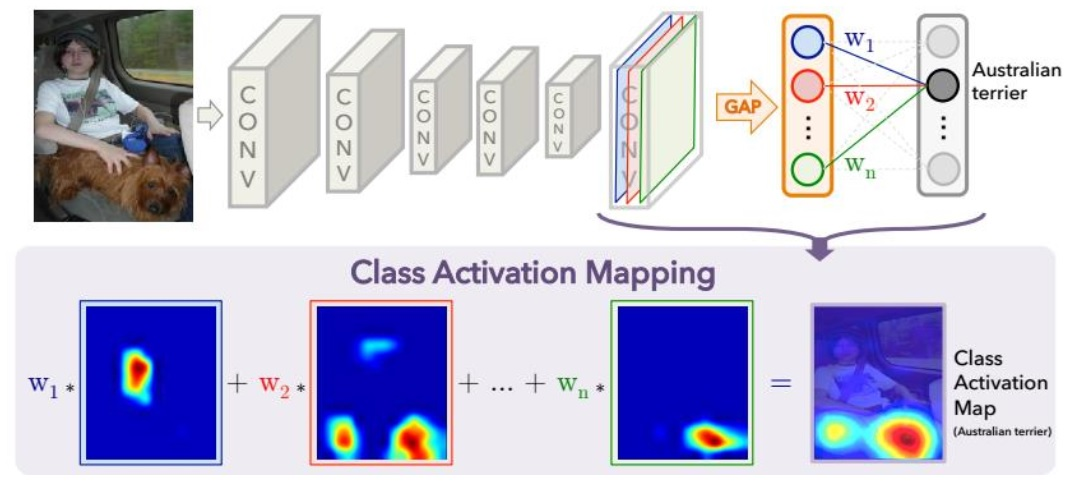

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: Tomato___Late_blight


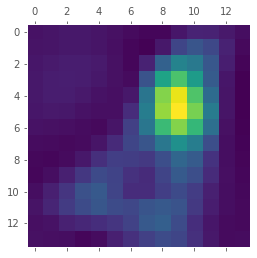

In [ ]:
img_path = '/content/PlantVillage/train/Tomato___Late_blight/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.JPG'

# Prepare image
img_array = prepare_image_for_prediction(img_path, size = (224,224))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
print("Predicted:", predict_class(img_path))

# Generate class activation heatmap
last_conv_layer_name = 'block5_conv3'
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Display Grad CAM
    plt.matshow(superimposed_img )
    plt.show()

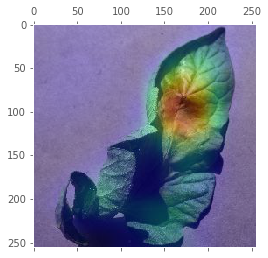

In [ ]:
display_gradcam(img_path, heatmap)